In [105]:
import time

import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

import stg_energy.fig3_active_subspaces.viz as viz
from pyloric import create_prior, simulate, summary_stats

from stg_energy.common import col, get_labels_8pt, svg

# Figure 3: additional nets
Here, we train 3 nets to predict the energy in AB/PD, LP, and PY. This will be used in fig5_cc

In [106]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
PANEL_quality_of_approx_LinReg = "../svg/panel_quality_of_approx_LinReg.svg"
PANEL_REG_D1_lin = "../svg/panel_reg_d1_lin.svg"
PANEL_REG_D2_lin = "../svg/panel_reg_d2_lin.svg"
PANEL_REG_D3_lin = "../svg/panel_reg_d3_lin.svg"
PANEL_REG_D4_lin = "../svg/panel_reg_d4_lin.svg"
PANEL_supp_performance1 = "../svg/panel_supp_performance1.svg"
PANEL_lin_reg = "../svg/panel_lin_reg.svg"
PANEL_REG_supp_bar = "../svg/panel_reg_supp_bar.svg"

### Load experimental data

In [108]:
# prior_11 = create_prior()
# dimensions_11 = 31
# lims_11 = np.asarray(
#     [-np.sqrt(3) * np.ones(dimensions_11), np.sqrt(3) * np.ones(dimensions_11)]
# ).T

# params_mean_11 = prior_11.mean.numpy()
# params_std_11 = prior_11.stddev.numpy()

In [109]:
# data = np.load("../../results/11deg_post_pred/11_deg_post_pred_close_to_obs.npz")

theta = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl"
)
x = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl"
)
seeds = np.load(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy"
)

theta_np = theta.to_numpy()
x_np = x.to_numpy()

In [110]:
sample_params = theta_np
sample_stats = x_np
print("There are", len(sample_stats), "datapoints in this dataset")

There are 35939 datapoints in this dataset


In [111]:
# sample_stats = data["sample_stats"]
# sample_params = data["sample_params"]
# sample_seeds = data["sample_seeds"]

In [112]:
energies = x['energies'].to_numpy()
summed_energies = np.sum(energies, axis=1)

# Panel 0: Fit regression net

In [113]:
energies = torch.as_tensor(energies)
sample_stats = torch.as_tensor(sample_stats)

In [114]:
print(energies.shape)

torch.Size([35939, 3])


In [115]:
num_test = 500

test_params = sample_params[:num_test]
train_params = sample_params[num_test:]
mean_params = np.mean(train_params, axis=0)
std_params = np.std(train_params, axis=0)

train_params_norm = (train_params - mean_params) / std_params
test_params_norm = (test_params - mean_params) / std_params

In [116]:
train_energy_ABPD = torch.sum(energies[num_test:], dim=1).unsqueeze(1)
test_energy_ABPD = torch.sum(energies[:num_test], dim=1).unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

In [117]:
from sklearn.linear_model import LinearRegression

In [118]:
regressor = LinearRegression()

In [119]:
fitted_reg = regressor.fit(train_params_norm, train_energy_ABPD_norm)

In [120]:
predictions = fitted_reg.predict(test_params_norm)

In [121]:
mean_energy

tensor(144816.1214, dtype=torch.float64)

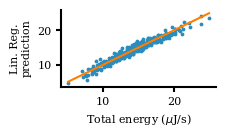

In [122]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = test_energy_ABPD_norm[:300] * std_energy + mean_energy
    unnorm_y = predictions[:300] * std_energy.numpy() + mean_energy.numpy()
    ax.scatter(x=unnorm_x.numpy()/10/1000, y=unnorm_y/10/1000, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x.numpy())/10/1000, np.max(unnorm_x.numpy())/10/1000, 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Total energy ($\mu$J/s)")
    ax.set_ylabel("Lin. Reg.\nprediction")
    plt.savefig(PANEL_quality_of_approx_LinReg, facecolor='None', transparent=False)

In [123]:
unnorm_y = predictions[:300] * std_energy.numpy() + mean_energy.numpy()
mse = np.mean(np.abs(unnorm_x.numpy()/10/1000 - unnorm_y/10/1000)**2)
print("mean squared error: ", mse)

mean squared error:  0.6574162893648844


## Bar plot of error

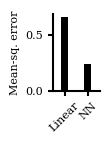

In [124]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(0.6, 1.0))
    mse_nn = 0.2359 # see notebook 02_build_figure.ipynb
    ax.bar(np.arange(2), [mse, mse_nn], facecolor='k', width=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel("Mean-sq. error")
    ax.set_xticks([0.0, 1.0])
    ax.set_xlim([-0.5, 1.5])
    ax.set_xticklabels(['Linear', 'NN'], rotation=45)
    plt.savefig(PANEL_REG_supp_bar, facecolor='None', transparent=False)

In [125]:
coeff = np.asarray([fitted_reg.coef_[0]])

In [126]:
coeff

array([[ 0.24303061,  0.24220313,  0.25153372, -0.21448089,  0.02655747,
        -0.09030624, -0.00697739, -0.02183087,  0.06547021,  0.12123631,
         0.28726876, -0.13600463, -0.00704035, -0.08904511,  0.01923278,
        -0.03653335,  0.48822558,  0.591764  ,  0.31211188, -0.24282591,
        -0.145721  , -0.1248469 ,  0.02081115, -0.08535344,  0.03766623,
        -0.01341702, -0.02270431,  0.03935958,  0.00822094, -0.01831972,
         0.08271188]], dtype=float32)

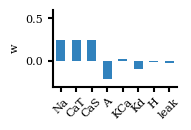

In [127]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars(coeff[:1, 0:8], ylim=[-0.3, 0.6], figsize=(1.6, 1.0), ylabel='w', plot_labels=True, color="#3182bd")
    plt.savefig(PANEL_REG_D1_lin, facecolor='None', transparent=False)

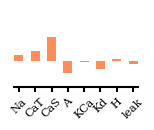

In [128]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars(coeff[:1, 8:16], ylim=[-0.3, 0.6], figsize=(1.6, 1.0), ylabel='', plot_labels=False, color="#fc8d59")
    plt.savefig(PANEL_REG_D2_lin, facecolor='None', transparent=False)

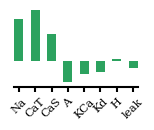

In [129]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars(coeff[:1, 16:24], ylim=[-0.3, 0.6], figsize=(1.6, 1.0), ylabel='', plot_labels=False, color="#2ca25f")
    plt.savefig(PANEL_REG_D3_lin, facecolor='None', transparent=False)

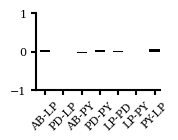

In [130]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(torch.as_tensor(coeff[:1, 24:]), ylim=[-0.3, 0.6], figsize=(1.6, 1.0), ylabel='', color="k")
    plt.savefig(PANEL_REG_D4_lin, facecolor='None', transparent=False)

In [131]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [134]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'weight': '800', 'color': "#b30000"}

f = Figure("20.3cm", "6.8cm",

    Panel(
          SVG(PANEL_lin_reg).scale(svg_scale).move(0, 0*factor_svg),
          Text("a", -2*factor_svg, -0.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 3.0*factor_svg),

    Panel(
          SVG(PANEL_quality_of_approx_LinReg).scale(svg_scale).move(0, 0*factor_svg),
        Text("b", -2*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(36.1*factor_svg, 1.0*factor_svg),

    Panel(
          SVG(PANEL_supp_performance1).scale(svg_scale).move(0, 0*factor_svg),
    ).move(73*factor_svg, 0.7*factor_svg),

    Panel(
          SVG(PANEL_REG_supp_bar).scale(svg_scale).move(0, 0*factor_svg),
        Text("c", -1.6*factor_svg, 2.0*factor_svg, **kwargs_text),
    ).move(117*factor_svg, 0.5*factor_svg),

    Panel(
          SVG(PANEL_REG_D1_lin).scale(svg_scale).move(0, 0*factor_svg),
        Text("d", -2*factor_svg, -1.0*factor_svg, **kwargs_text),
        Text("AB/PD", 16.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt),
    ).move(2*factor_svg, 26*factor_svg),

    Panel(
          SVG(PANEL_REG_D2_lin).scale(svg_scale).move(0, 0*factor_svg),
        Text("LP", 11.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt),
    ).move(33*factor_svg, 26*factor_svg),

    Panel(
          SVG(PANEL_REG_D3_lin).scale(svg_scale).move(0, 0*factor_svg),
        Text("PY", 11.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt),
    ).move(58*factor_svg, 26*factor_svg),

    Panel(
          SVG(PANEL_REG_D4_lin).scale(svg_scale).move(0, 0*factor_svg),
        Text("Synapses", 8.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt),
    ).move(83*factor_svg, 26*factor_svg),

)

!mkdir -p fig
f.save("../fig/fig3_supp4.svg")
svg('../fig/fig3_supp4.svg')